# Imports e carregamentos

In [1]:
import pandas as pd

import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_live_engineer_filtered.csv', encoding='utf-8')

## Preprocessamento

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    print("Dados separados em características (X) e variável alvo (y).")
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    
    print("Preprocessador criado com transformações para características numéricas e categóricas.")
    return preprocessor.fit(X)

# # Preparando os dados
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)
print("Preprocessador ajustado aos dados.")

# Salvando o preprocessador para uso futuro
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)
    print("Preprocessador salvo em '../models/preprocessor.pickle'.")

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
print("Dados transformados pelo preprocessador.")

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)
print("Dados divididos em conjuntos de treino e teste.")

Dados separados em características (X) e variável alvo (y).
Preprocessador criado com transformações para características numéricas e categóricas.
Preprocessador ajustado aos dados.
Preprocessador salvo em '../models/preprocessor.pickle'.
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.


## H2O AutoML

### Conversão de Dados a Treinamento

In [4]:
# Inicializar o H2O
h2o.init()

# Convertendo dados do numpy para H2OFrame
X_train_h2o = h2o.H2OFrame(pd.DataFrame(X_train, columns=["C" + str(i) for i in range(X_train.shape[1])]))
X_test_h2o = h2o.H2OFrame(pd.DataFrame(X_test, columns=["C" + str(i) for i in range(X_test.shape[1])]))
y_train_h2o = h2o.H2OFrame(pd.DataFrame(y_train, columns=["result"]))
y_test_h2o = h2o.H2OFrame(pd.DataFrame(y_test, columns=["result"]))

# Convert Pandas DataFrame or NumPy array to H2OFrame
X_train_h2o = h2o.H2OFrame(X_train)
X_test_h2o = h2o.H2OFrame(X_test)

y_train_df = y_train.to_frame()
y_train_h2o = h2o.H2OFrame(y_train_df)
y_train_h2o['result'] = y_train_h2o['result'].asfactor()

y_test_df = y_test.to_frame()
y_test_h2o = h2o.H2OFrame(y_test_df)
y_test_h2o['result'] = y_test_h2o['result'].asfactor()

# Check the shape again
print("X_train_h2o shape:", X_train_h2o.shape)
print("y_train_h2o shape:", y_train_h2o.shape)
print("X_test_h2o shape:", X_test_h2o.shape)
print("y_test_h2o shape:", y_test_h2o.shape)

# Combine them back into one frame
train_data = X_train_h2o.cbind(y_train_h2o)
test_data = X_test_h2o.cbind(y_test_h2o)

# Identify predictors and response
x = train_data.columns

y = "result"
x.remove(y)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Python310\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Pichau\AppData\Local\Temp\tmpjwytu0tg
  JVM stdout: C:\Users\Pichau\AppData\Local\Temp\tmpjwytu0tg\h2o_Pichau_started_from_python.out
  JVM stderr: C:\Users\Pichau\AppData\Local\Temp\tmpjwytu0tg\h2o_Pichau_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,3 months and 14 days
H2O_cluster_name:,H2O_from_python_Pichau_pu199l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.965 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
X_train_h2o shape: (92905, 60)
y_train_h2o shape: (92905, 1)
X_test_h2o shape: (23227, 60)
y_test_h2o shape: (23227, 1)


### Treinamento

In [5]:
# Run AutoML
aml = H2OAutoML(max_models=20, sort_metric='aucpr')
aml.train(x=x, y=y, training_frame=train_data)

# View leaderboard
lb = aml.leaderboard
print(lb)

#save the model
model_path = h2o.save_model(model=aml.leader, path="../models/", force=True)

AutoML progress: |
23:34:57.949: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    aucpr       auc    logloss    mean_per_class_error      rmse       mse
StackedEnsemble_BestOfFamily_1_AutoML_1_20231206_233457  0.927071  0.928786   0.349485                0.14919   0.327195  0.107057
StackedEnsemble_AllModels_1_AutoML_1_20231206_233457     0.927045  0.928776   0.349508                0.148327  0.327202  0.107061
GBM_grid_1_AutoML_1_20231206_233457_model_5              0.924752  0.925668   0.379924                0.150702  0.342116  0.117043
DRF_1_AutoML_1_20231206_233457                           0.910639  0.913823   0.466974                0.17062   0.386865  0.149665
GBM_4_AutoML_1_20231206_233457                           0.901236  0.900263   0.441631                0.187825  0.37535   0.140888
GBM_grid_1_AutoML_1_20231206_233457_model_4             

### Avaliação de métricas

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


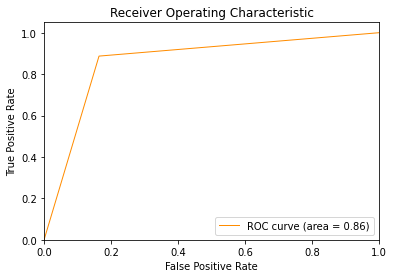

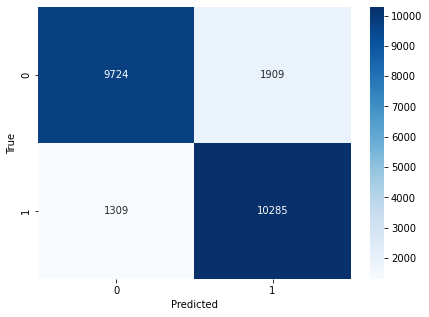

In [6]:
# h2o.init()
# loaded_model = h2o.load_model("../models/model_automl")
loaded_model = h2o.load_model(model_path)
y_pred_prob = loaded_model.predict(X_test_h2o)
y_pred = h2o.as_list(y_pred_prob)
y_pred_prob = y_pred['predict'].tolist()

# Falsos positivos, verdadeiros positivos e limiares
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Área sob a curva
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de confusão
y_pred_round = [round(value) for value in y_pred_prob]
cm = confusion_matrix(y_test.to_list(), y_pred_round)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [7]:
from sklearn.metrics import classification_report

# Certifique-se de que y_test é um array ou lista
# Se y_test for um DataFrame ou Series, converta usando .tolist() ou .values
y_test_list = y_test.tolist() if hasattr(y_test, 'tolist') else y_test

# Gerando o relatório de classificação
report = classification_report(y_test_list, y_pred_round, target_names=['Classe 0', 'Classe 1'])

# Imprimindo o relatório de classificação
print("Relatório de Classificação:")
print(report)


Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.88      0.84      0.86     11633
    Classe 1       0.84      0.89      0.86     11594

    accuracy                           0.86     23227
   macro avg       0.86      0.86      0.86     23227
weighted avg       0.86      0.86      0.86     23227



### Na prática

In [8]:
df.head(1699).tail(1)['result']

1698    0
Name: result, dtype: int64

In [9]:
# h2o.init()
# loaded_model = h2o.load_model("../models/model_automl")
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
Xht = h2o.H2OFrame(Xht)
loaded_model.predict(Xht)

Parse progress: |

████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.510118,0.489882


In [10]:
# h2o.export_file(frame=lb, path='lb.csv', force=True)

In [11]:
# obter o valor da predição colocando o item preditor em uma lista e pegando o primeiro valor
h2o.as_list(loaded_model.predict(Xht)).loc[0, 'p1']

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


0.4898815900275672

### Importancia dos atributos

In [12]:
import shap
# função de previsão para o modelo H2O
def model_predict(data_as_array):
    h2o_df = h2o.H2OFrame(pd.DataFrame(data_as_array, columns=["C" + str(i) for i in range(data_as_array.shape[1])]))
    preds = loaded_model.predict(h2o_df)
    preds_df = preds.as_data_frame()
    # Assegurar que as previsões estejam no formato correto (array 2D com duas colunas)
    return preds_df.iloc[:, -2:].values


# Converter H2OFrame para DataFrame do pandas
X_train_pd = h2o.as_list(X_train_h2o)
X_test_pd = h2o.as_list(X_test_h2o)

# explainer usando KernelExplainer para um modelo H2O
explainer = shap.KernelExplainer(model_predict, X_train_pd.iloc[:50])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [13]:
# Calcula os valores SHAP para um subconjunto do conjunto de teste
# shap_values_h2o = explainer.shap_values(X_test_pd[:50])

In [14]:
# # Obter os nomes das colunas numéricas
# numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

# # Obter os nomes das colunas após a transformação
# # Para as características numéricas, permanecem os mesmos
# transformed_numeric_features = numeric_features

# # como so tem uma caracteristica categorica:
# categories = preprocessor.named_transformers_['cat'].categories_
# transformed_categorical_features = [
#     f'league_{category}' for category in categories[0][1:]  # drop='first' remove a primeira categoria
# ]

# # Combina os dois
# all_transformed_features = transformed_numeric_features + transformed_categorical_features

# shap.summary_plot(shap_values_h2o, features=X_test_pd.iloc[:50], feature_names=all_transformed_features, max_display=X_test_pd.iloc[:50].shape[1])